# IF702 Redes Neurais
Este notebook contém um script base para o projeto da disciplina IF702 Redes Neurais.

In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Leitura e Limpeza dos Dados

A leitura dos dados é feita utilizando a biblioteca `pandas`. O presente exemplo importa a base de dados `mammography`. Caso você esteja trabalhando com outro data set, modifique este trecho de código.
Para importar o conjunto de dados do PAKDD, use a função `pd.read_table` ao invés da `pd.read_csv`.

In [22]:
#lendo base de dados
data_set = pd.read_csv('mammography.csv')
# type(data_set)
data_set.columns = ['X1','X2','X3','X4','X5','X6','result']
data_set = data_set.drop('X6',1)
# print (data_set)

In [23]:
data_set.drop_duplicates(keep=False,inplace=True)  # Remove exemplos repetidos
# data_set

In [25]:
# Estatísticas sobre as variáveis
data_set.describe()

,X1,X2,X4,X5,X6,result
count,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000,7811.000000
mean,0.336932,0.202804,0.371068,0.163124,0.408268,-0.935220
std,1.026104,1.138124,0.987447,1.159092,0.937493,0.354091
min,-0.784415,-0.452501,-0.859553,-0.377866,-0.945723,-1.000000
25%,-0.142623,-0.408265,-0.859553,-0.377866,-0.945723,-1.000000
50%,0.113315,-0.271133,0.557336,-0.377866,0.852069,-1.000000
75%,0.510687,0.224310,1.028859,0.389228,1.132403,-1.000000
max,31.508443,5.085849,9.591164,23.617122,1.949027,1.000000


Agora vamos separar o data set em atributos dependentes (X = features) e independentes (y = classe). No caso do `mammography` a classe majoritária está codificada como -1 e a classe minoritária está codificada como 1. Para treinar nossa rede neural precisamos que os valores de classe sejam 0 e 1 (restrição da biblioteca `keras`), assim modificamos a codificação da majoritária para 0.

Perceba que esse pré-processamento varia de data set para data set.

## Divisão dos Dados em Treino, Validação, e Teste

Aqui dividimos o data set em treino, validação e teste de maneira estratificada.

In [24]:
#separando classes
# data_set.columns = ['X1','X2','X3','X4','X5','X6','result']
major = data_set[data_set.result == -1]
minor = data_set[data_set.result == 1]

## 50% train, 25% validation, 25% test
major_train, major_test = train_test_split(major, test_size = 1/4, random_state = 42)
major_train, major_val = train_test_split(major_train, test_size = 1/3, random_state = 42)

minor_train, minor_test = train_test_split(minor, test_size = 1/4, random_state = 42)
minor_train, minor_val = train_test_split(minor_train, test_size = 1/3, random_state = 42)

## resizing
minor_train = np.resize(minor_train, major_train.shape)
minor_val = np.resize(minor_val, major_val.shape)

## shuffleling
train = np.concatenate((major_train, minor_train), axis=0)
val = np.concatenate((major_val, minor_val), axis=0)
test = np.concatenate((major_test, minor_test), axis=0)

np.random.shuffle(train)
np.random.shuffle(val)
np.random.shuffle(test)

#separating dataset into features table and classes column
train_f = train[:,:-1]
train_i = np.where(train[:,-1] == -1, 0, 1)
val_f = val[:,:-1]
val_i = np.where(val[:,-1] == -1, 0, 1)
test_f = test[:,:-1]
test_i = np.where(test[:,-1] == -1, 0, 1)

print (train_f)
print (train_i)

[[ 0.18767387 -0.32864006 -0.45638679  1.4054445   4.6050526 ]
 [ 1.0217155  -0.27113323 -0.41130523  5.4784729  -0.37786573]
 [-0.11907863 -0.38614689 -0.230979   -0.85955255 -0.37786573]
 ..., 
 [ 0.81981101  0.25527543 -0.27606055 -0.85955255 -0.37786573]
 [ 0.4644456  -0.18708479 -0.32114211  2.2645231   2.3665258 ]
 [ 1.3919866   0.15795618 -0.54654991  2.1096695   7.3765746 ]]
[1 1 0 ..., 0 1 1]


## Sampling dos Dados e Normalização

Para testar o comportamento da rede com diferentes funções de sampling, as mesmas devem ser implementadas e aplicadas ao conjunto de treinamento antes da normalização dos dados (você também pode investigar qual o efeito de aplicar o sampling após a normalização).

In [7]:
## TO DO -- Implementar as funções de sampling a serem utilizadas

É importante lembrar de normalizar os dados. A classe `StandardScaler` centraliza as variáveis e transforma as features para terem variância unitária. Você pode testar outras opções como o `MinMaxScaler`.

Todas as alternativas estão disponíveis em:
http://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing.

In [25]:
# normalização dos dados
scaler = StandardScaler()
train_f = scaler.fit_transform(train_f)
val_f = scaler.transform(val_f)
test_f = scaler.transform(test_f)

# print (train_f)

## Definição e Treino da Rede

Aqui definimos a arquitetura da nossa rede neural e treinamos ela.

No presente exemplo a rede possui apenas uma camada escondida. O código é bem intuitivo e a adição de novas camadas pode ser feita através da função `add`.

Para treinar a rede várias funções de otimização estão disponíveis. 

Confira os exemplos em: https://keras.io/optimizers/

O treinamento da rede pode ser interrompido baseado na performance dela em um conjunto de validação através de callbacks.

Confira a documentação da classe `EarlyStopping`: https://keras.io/callbacks/

In [27]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

# Agora adicionamos a primeira camada escondida contendo 16 neurônios e função de ativação
# tangente hiperbólica. Por ser a primeira camada adicionada à rede, precisamos especificar
# a dimensão de entrada (número de features do data set), que no caso do mammography são 6.
classifier.add(Dense(16, activation='selu', input_dim=5))

classifier.add(Dense(20, activation='selu',))

classifier.add(Dense(10, activation='relu',))

classifier.add(Dense(30, activation='tanh',))

classifier.add(Dense(15, activation='selu',))

classifier.add(Dense(8, activation='selu',))

# Em seguida adicionamos a camada de saída. Como nosso problema é binário só precisamos de
# 1 neurônio com função de ativação sigmoidal. A partir da segunda camada adicionada keras já
# consegue inferir o número de neurônios de entrada (16) e nós não precisamos mais especificar.
classifier.add(Dense(1, activation='selu'))

# Por fim compilamos o modelo especificando um otimizador, a função de custo, e opcionalmente
# métricas para serem observadas durante treinamento.
classifier.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=6)
# Para treinar a rede passamos o conjunto de treinamento e especificamos o tamanho do mini-batch,
# o número máximo de épocas, e opcionalmente callbacks. No presente exemplo utilizamos early
# stopping para interromper o treinamento caso a performance não melhore em um conjunto de validação.
history = classifier.fit(train_f, train_i, batch_size=64, epochs=150, 
                         callbacks=[early_stopping], validation_data=(val_f, val_i))

Train on 7592 samples, validate on 3796 samples
Epoch 1/150
7592/7592 [==============================] - 0s - loss: 0.0990 - val_loss: 0.1068
Epoch 2/150
7592/7592 [==============================] - 0s - loss: 0.0650 - val_loss: 0.0977
Epoch 3/150
7592/7592 [==============================] - 0s - loss: 0.0588 - val_loss: 0.1017
Epoch 4/150
7592/7592 [==============================] - 0s - loss: 0.0548 - val_loss: 0.1023
Epoch 5/150
7592/7592 [==============================] - 0s - loss: 0.0533 - val_loss: 0.1031
Epoch 6/150
7592/7592 [==============================] - 0s - loss: 0.0507 - val_loss: 0.1065
Epoch 7/150
7592/7592 [==============================] - 0s - loss: 0.0497 - val_loss: 0.1007
Epoch 8/150
7592/7592 [==============================] - 0s - loss: 0.0495 - val_loss: 0.1091
Epoch 9/150
7592/7592 [==============================] - 0s - loss: 0.0490 - val_loss: 0.1048


In [17]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

# Agora adicionamos a primeira camada escondida contendo 16 neurônios e função de ativação
# tangente hiperbólica. Por ser a primeira camada adicionada à rede, precisamos especificar
# a dimensão de entrada (número de features do data set), que no caso do mammography são 6.
classifier.add(Dense(50, activation='relu', input_dim=6))

classifier.add(Dense(40, activation='relu',))

classifier.add(Dense(30, activation='relu',))

# classifier.add(Dense(30, activation='relu',))

classifier.add(Dense(15, activation='relu',))

classifier.add(Dense(8, activation='relu',))

# Em seguida adicionamos a camada de saída. Como nosso problema é binário só precisamos de
# 1 neurônio com função de ativação sigmoidal. A partir da segunda camada adicionada keras já
# consegue inferir o número de neurônios de entrada (16) e nós não precisamos mais especificar.
classifier.add(Dense(1, activation='relu'))

# Por fim compilamos o modelo especificando um otimizador, a função de custo, e opcionalmente
# métricas para serem observadas durante treinamento.
classifier.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
# Para treinar a rede passamos o conjunto de treinamento e especificamos o tamanho do mini-batch,
# o número máximo de épocas, e opcionalmente callbacks. No presente exemplo utilizamos early
# stopping para interromper o treinamento caso a performance não melhore em um conjunto de validação.
history = classifier.fit(train_f, train_i, batch_size=64, epochs=150, 
                         callbacks=[early_stopping], validation_data=(val_f, val_i))

Train on 7592 samples, validate on 3796 samples
Epoch 1/150
7592/7592 [==============================] - 1s - loss: 0.1940 - val_loss: 0.1029
Epoch 2/150
7592/7592 [==============================] - 1s - loss: 0.0591 - val_loss: 0.1018
Epoch 3/150
7592/7592 [==============================] - 1s - loss: 0.0430 - val_loss: 0.1016
Epoch 4/150
7592/7592 [==============================] - 1s - loss: 0.0359 - val_loss: 0.1012
Epoch 5/150
7592/7592 [==============================] - 0s - loss: 0.0314 - val_loss: 0.1008
Epoch 6/150
7592/7592 [==============================] - 0s - loss: 0.0308 - val_loss: 0.1171
Epoch 7/150
7592/7592 [==============================] - 1s - loss: 0.0259 - val_loss: 0.1010
Epoch 8/150
7592/7592 [==============================] - 1s - loss: 0.0243 - val_loss: 0.1093
Epoch 9/150
7592/7592 [==============================] - 1s - loss: 0.0244 - val_loss: 0.1138
Epoch 10/150
7592/7592 [==============================] - 1s - loss: 0.0219 - val_loss: 0.1124
Epoch 11/15

In [21]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

# Agora adicionamos a primeira camada escondida contendo 16 neurônios e função de ativação
# tangente hiperbólica. Por ser a primeira camada adicionada à rede, precisamos especificar
# a dimensão de entrada (número de features do data set), que no caso do mammography são 6.
classifier.add(Dense(100, activation='relu', input_dim=6))

classifier.add(Dense(110, activation='relu',))

classifier.add(Dense(80, activation='relu',))

classifier.add(Dense(90, activation='relu',))

classifier.add(Dense(70, activation='relu',))

classifier.add(Dense(50, activation='relu',))

classifier.add(Dense(70, activation='relu',))

classifier.add(Dense(30, activation='relu',))

classifier.add(Dense(20, activation='relu',))

classifier.add(Dense(10, activation='relu',))

# Em seguida adicionamos a camada de saída. Como nosso problema é binário só precisamos de
# 1 neurônio com função de ativação sigmoidal. A partir da segunda camada adicionada keras já
# consegue inferir o número de neurônios de entrada (16) e nós não precisamos mais especificar.
classifier.add(Dense(1, activation='relu'))

# Por fim compilamos o modelo especificando um otimizador, a função de custo, e opcionalmente
# métricas para serem observadas durante treinamento.
classifier.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
# Para treinar a rede passamos o conjunto de treinamento e especificamos o tamanho do mini-batch,
# o número máximo de épocas, e opcionalmente callbacks. No presente exemplo utilizamos early
# stopping para interromper o treinamento caso a performance não melhore em um conjunto de validação.
history = classifier.fit(train_f, train_i, batch_size=64, epochs=150, 
                         callbacks=[early_stopping], validation_data=(val_f, val_i))

Train on 7592 samples, validate on 3796 samples
Epoch 1/150
7592/7592 [==============================] - 0s - loss: 0.1371 - val_loss: 0.1052
Epoch 2/150
7592/7592 [==============================] - 0s - loss: 0.0432 - val_loss: 0.0980
Epoch 3/150
7592/7592 [==============================] - 0s - loss: 0.0320 - val_loss: 0.1088
Epoch 4/150
7592/7592 [==============================] - 0s - loss: 0.0348 - val_loss: 0.1030
Epoch 5/150
7592/7592 [==============================] - 0s - loss: 0.0342 - val_loss: 0.1058
Epoch 6/150
7592/7592 [==============================] - 0s - loss: 0.0304 - val_loss: 0.1127
Epoch 7/150
7592/7592 [==============================] - 0s - loss: 0.0236 - val_loss: 0.1070
Epoch 8/150
7592/7592 [==============================] - 0s - loss: 0.0261 - val_loss: 0.1239


In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
# Para treinar a rede passamos o conjunto de treinamento e especificamos o tamanho do mini-batch,
# o número máximo de épocas, e opcionalmente callbacks. No presente exemplo utilizamos early
# stopping para interromper o treinamento caso a performance não melhore em um conjunto de validação.
history = classifier.fit(X_train, y_train, batch_size=64, epochs=150, 
                         callbacks=[early_stopping], validation_data=(X_val, y_val))

Train on 3922 samples, validate on 1961 samples
Epoch 1/150
3922/3922 [==============================] - 0s - loss: 0.0248 - val_loss: 0.0219
Epoch 2/150
3922/3922 [==============================] - 0s - loss: 0.0211 - val_loss: 0.0199
Epoch 3/150
3922/3922 [==============================] - 0s - loss: 0.0205 - val_loss: 0.0202
Epoch 4/150
3922/3922 [==============================] - 0s - loss: 0.0200 - val_loss: 0.0188
Epoch 5/150
3922/3922 [==============================] - 0s - loss: 0.0195 - val_loss: 0.0193
Epoch 6/150
3922/3922 [==============================] - 0s - loss: 0.0192 - val_loss: 0.0180
Epoch 7/150
3922/3922 [==============================] - 0s - loss: 0.0188 - val_loss: 0.0176
Epoch 8/150
3922/3922 [==============================] - 0s - loss: 0.0183 - val_loss: 0.0178
Epoch 9/150
3922/3922 [==============================] - 0s - loss: 0.0184 - val_loss: 0.0167
Epoch 10/150
3922/3922 [==============================] - 0s - loss: 0.0183 - val_loss: 0.0175
Epoch 11/15

In [10]:
#utilizado para salvar os pesos da rede
classifier.save_weights("pesos.h5", overwrite=True)

Algumas funções auxiliares.

In [12]:
def extract_final_losses(history):
    """Função para extrair o melhor loss de treino e validação.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    Dicionário contendo o melhor loss de treino e de validação baseado 
    no menor loss de validação.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history):
    """Função para plotar as curvas de erro do treinamento da rede neural.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    A função gera o gráfico do treino da rede e retorna None.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves', xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()

<IPython.core.display.Javascript object>


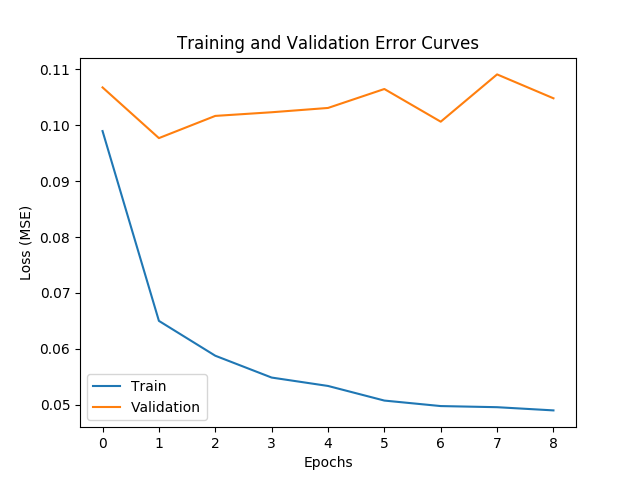

In [28]:
plot_training_error_curves(history)

## Predições no Conjunto de Teste

Agora utilizamos a nossa rede para fazer predições no conjunto de teste e computar métricas de desempenho.

Além das métricas utilizadas aqui, mais métricas de desempenho podem ser encontradas em: http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics

In [22]:
## Fazer predições no conjunto de teste
y_pred = classifier.predict(test_f)
y_pred_class = classifier.predict_classes(test_f, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(test_i, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(test_i, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall_score(test_i, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision_score(test_i, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1_score(test_i, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(test_i, y_pred)))

Matriz de confusão
[[1826   72]
 [  11   53]]

Train Loss:       0.0440
Validation Loss:  0.0985
Accuracy:         0.9577
Recall:           0.8281
Precision:        0.4240
F1:               0.5608
AUROC:            0.9376
